# Business Understanding
First things first, following the CRISP-DM process methodology our first task is to understand the problem, from the <a href="https://www.kaggle.com/airbnb/boston" target="_blank">dataset</a> description we can see that it describes the listing activity of homestays in Boston, MA. Next we should find the questions that we want answered. Some intriguing ones are:
1. How much do areas, as well as time frames, influence AirBNB home earnings?
2. How can reviews affect the prices of AirBNB homes?
3. Does the internet availability affect the number of listings af an AirBNB home? and if so, should a host invest in making this service available for his listing?
4. What percentage of people look for an AirBNB home with a washer/dryer available? And how much more do they have to pay to get this service?
3. Can we use this data to predict the price of an AirBNB home?


Now it's time to have a look at the data and try to understand it.

***

**Import Statements**

In [1]:
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# Read the csv files and store them in dataframes
calender = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

# Getting familiar with data 
First we get familiar with the data by asking some questions
* what columns are available in the dataset? 
* What percentage of these columns are null values? 
* If the data is to be fed to a machine learning algorithm, what would be the features and what would be the output of the model? 


This can help us filter which rows to remove from dataset, and which to impute.

In [3]:
calender.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


We can see that the calender dataset has 4 columns, one is the listing id which most probably won't have any null values, the date of the listing, the availablility which should probably be converted to a boolean column, and the price, which will most likely be the output a machine learning model which tries to estimate the price. Next we will check the **size** of the dataset, the **type** of each column, and the **percentage of null values** for each column.

In [4]:
# shape
calender.shape

(1308890, 4)

In [5]:
calender.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [6]:
# percentage of null values
calender.isnull().sum()/calender.shape[0]

listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64

The calender dataframe has more than a million rows! Furthermore the **available** and **price** columns should not have an object type, they need to be converted to their correct types. We can also see that more than half of the data do not have a price, so dropping those rows seems like a logical idea if the price value is mandatory. Next we do the same for the listings and reviews dataframes.

In [7]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [8]:
listings.shape

(3585, 95)

In [9]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [10]:
# percentage of null values
(listings.isnull().sum()/listings.shape[0]).sort_values(ascending = False)

neighbourhood_group_cleansed        1.000000
jurisdiction_names                  1.000000
license                             1.000000
has_availability                    1.000000
square_feet                         0.984379
monthly_price                       0.752301
weekly_price                        0.751185
security_deposit                    0.625662
notes                               0.550907
interaction                         0.433473
access                              0.415342
neighborhood_overview               0.394700
host_about                          0.365132
transit                             0.359833
house_rules                         0.332497
cleaning_fee                        0.308787
space                               0.294840
review_scores_accuracy              0.229568
review_scores_location              0.229289
review_scores_value                 0.229010
review_scores_checkin               0.228731
review_scores_cleanliness           0.228173
review_sco

We can conclude the following about the listings dataset from the above results:
* There are 95 columns 4 of which are completely null, 1 has 98.4% null values, and 4 have more than 50% null values
* The id is the same as the listing_id from calender dataset so they can be joined together on that column
* The price column doesn't have any null values, which is good for estimating price for new data


In [11]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [12]:
reviews.shape

(68275, 6)

In [13]:
# percentage of null values
(reviews.isnull().sum()/reviews.shape[0]).sort_values(ascending = False)

comments         0.000776
reviewer_name    0.000000
reviewer_id      0.000000
date             0.000000
id               0.000000
listing_id       0.000000
dtype: float64

We can see that the reviews dataset has 6 columns, one of them is a listing id column, therefore, we can use the listing id to join the 3 dataframes together. However, we won't be needing this dataframe since it doesn't contain information relative to our questions.

***

# Data Preparation
Our next step is to prepare the data, this includes:
* Removing unnecessary rows and columns
* Refactor data entries to be suitable for modeling
* Assigning the correct dtype for each column
* Imputing numerical values
* Encode categorical values
* Merging the 2 dataframes into 1 dataframe


 **Calender**

In [14]:
# return this setting
pd.set_option('display.max_rows', 60)

In [15]:
# drop rows where there is no price value
calender = calender[~calender['price'].isnull()]
calender.shape

(643037, 4)

In [16]:
# Make sure available column in calender is boolean
calender['available'].unique()

array(['t'], dtype=object)

We can find here that the available column has the same value for all rows, the ' f ' value came from NaN prices, we can therefore drop the column.

In [17]:
# drop 'available' column
calender.drop(['available'],inplace = True, axis = 1)

In [18]:
# check that the prices are all in $
calender[calender['price'].apply(lambda x: '$' in x)].shape

(643037, 3)

In [19]:
# remove the '$' and ',' sign from price and convert the price column dtype to int
calender['price'] = calender['price'].apply(lambda x: int(float(re.sub('[$,]','',x))))

In [20]:
# change calender format from object to datetime
calender['date'] = pd.to_datetime(calender['date'])

In [21]:
# check that everything is going well
calender.head()

,listing_id,date,price
365,3075044,2017-08-22,65
366,3075044,2017-08-21,65
367,3075044,2017-08-20,65
368,3075044,2017-08-19,75
369,3075044,2017-08-18,75


**Listings**

We can drop columns containing more than 90% missing values for starters, and after merging the dataframes we can decide which columns are valuable to answer our questions and which we can get rid of. In our case these columns are **neighbourhood_group_cleansed** , **jurisdiction_names**, **license**, **has_availability**, and **square_feet**.
We can also make a new column which describes the **final_review_score** by using the **review_scores_rating** column while considering the accuracy of the review using the **review_scores_accuracy** column, and fill its missing values.

In [22]:
listings.shape

(3585, 95)

In [23]:
listings.drop(['neighbourhood_group_cleansed','jurisdiction_names','license','has_availability','square_feet'],axis=1,inplace=True)

We can also drop columns with no variations

In [24]:
listings.drop(['requires_license'],inplace = True, axis = 1)
listings.drop(['experiences_offered'],inplace = True, axis = 1)
# same as host_listings_count column
listings.drop(['host_total_listings_count'],inplace = True, axis = 1)

In [25]:
# check that the prices are all in $
print(listings[listings['price'].apply(lambda x: '$' in x)].shape)
listings['price'] = listings['price'].apply(lambda x: int(float(re.sub('[$,]','',x))))

(3585, 87)


In [26]:
# do the same for cleaning_fee and extra_people
listings['extra_people'] = listings['extra_people'].apply(lambda x: int(float(re.sub('[$,]','',x))))
listings['cleaning_fee'] = listings['cleaning_fee'].apply(lambda x: int(float(re.sub('[$,]','',x))) if isinstance(x, str) else x )

Since **cleaning_fee** has some missing values we impute them using the **ffill** and **bfill** methods, we first want to sort them with respect to the columns they have high correlations with, and then perform the imputing.

In [27]:
listings.corr()['cleaning_fee'].sort_values(ascending=False)

cleaning_fee                      1.000000e+00
price                             4.902099e-01
accommodates                      3.947616e-01
calculated_host_listings_count    3.628134e-01
beds                              3.563019e-01
host_listings_count               3.150604e-01
bedrooms                          3.070547e-01
bathrooms                         2.511430e-01
availability_90                   2.348651e-01
availability_30                   2.254651e-01
availability_60                   2.248960e-01
availability_365                  2.206106e-01
latitude                          1.798688e-01
guests_included                   1.574342e-01
minimum_nights                    1.525910e-01
longitude                         1.310719e-01
review_scores_location            1.083411e-01
review_scores_cleanliness         9.480017e-02
review_scores_rating              1.362272e-02
scrape_id                        -8.100912e-16
maximum_nights                   -9.132352e-03
extra_people 

 We can select from above the **price**, **accommodates**, and **beds** columns. Next we impute the missing values.

In [28]:
# listings.sort_values(['price','accommodates','beds'],ascending = False)['cleaning_fee'] = listings.sort_values(['price','accommodates','beds'],ascending = False)['cleaning_fee'].fillna(method='ffill').fillna(method='bfill')
listings['cleaning_fee'] = listings.sort_values(['price','accommodates','beds'],ascending = False)['cleaning_fee'].fillna(method='ffill').fillna(method='bfill')
listings['cleaning_fee'] = listings['cleaning_fee'].astype(int);

In [29]:
# create new column to hold the final review score value which is between 0 and 10
listings['final_review_score'] = listings['review_scores_rating']*listings['review_scores_accuracy']/100

# fill its missing values with the mean of the column
listings['final_review_score'].fillna(listings['final_review_score'].mean(),inplace = True);

# convert the column to integers from 0 to 10
listings['final_review_score'] = listings['final_review_score'].round().astype(int)

In [30]:
# change host_is_superhost, host_identity_verified, instant_bookable,
# require_guest_profile_picture, and require_guest_phone_verification to boolean
listings['host_is_superhost'] = (listings['host_is_superhost']=='t')*1
listings['host_identity_verified'] = (listings['host_identity_verified']=='t')*1
listings['instant_bookable'] = (listings['instant_bookable']=='t')*1
listings['require_guest_profile_picture'] = (listings['require_guest_profile_picture']=='t')*1
listings['require_guest_phone_verification'] = (listings['require_guest_phone_verification']=='t')*1
listings['host_is_superhost'] = (listings['host_is_superhost']=='t')*1

# convert rooms to int but first impute the missing values depending on the accommodates column
# This can be seen using the same correlation function used in cleaning_fee
listings['beds'] = listings.sort_values(['accommodates'],ascending=False)['beds'].fillna(method = 'ffill').fillna(method='bfill').astype(int)
listings['bedrooms'] = listings.sort_values(['accommodates'],ascending=False)['bedrooms'].fillna(method = 'ffill').fillna(method='bfill').astype(int)
listings['bathrooms'] = listings.sort_values(['accommodates'],ascending=False)['bathrooms'].fillna(method = 'ffill').fillna(method='bfill').astype(int)

# impute review_scores_location
listings['review_scores_location'] = listings.sort_values(['review_scores_rating'],ascending=False)['review_scores_location'].fillna(method = 'ffill').fillna(method='bfill').astype(int)

C:\Users\Ahmad\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Great!, Now for the categoical variables we should select some and use the get_dummies method for encoding. We select the below columns:

* host_response_time
* neighbourhood_cleansed
* property_type
* room_type
* bed_type
* amenities
* cancellation_policy

In [31]:
listings[['host_response_time',
'neighbourhood_cleansed',
'property_type',
'room_type',
'bed_type',
'amenities',
'cancellation_policy']].isnull().sum()

host_response_time        471
neighbourhood_cleansed      0
property_type               3
room_type                   0
bed_type                    0
amenities                   0
cancellation_policy         0
dtype: int64

We can see that the property type and host response type will require some imputation, other than this all seems fine except the amenities which will further modification.

In [32]:
# Remove all unnecessary characters and keep the ',' character to be used as a separator
listings['amenities']= listings['amenities'].apply(lambda x: re.sub('[{}"\'()]','',x))
amen_dummies_df = listings['amenities'].str.get_dummies(sep = ',')

That's great, but it requires further cleaning, for example **Washer / Dryer**, **Dryer** and **Washer** columns can be merged in one column, same for **Wireless Internet** and **Internet**, **Cable TV** and **TV**, **Other pets** and **Pets Allowed**, **translation missing: en.hosting_amenity_49** and **translation missing: en.hosting_amenity_49** should be dropped as their names don't indicate anything, **Carbon Monoxide Detector**, **Smoke Detector**, and **Smoking Allowed** should also be combined.

In [33]:
# Washer/Dryer
amen_dummies_df['Washer / Dryer'] = (amen_dummies_df['Dryer'] | amen_dummies_df['Washer'])
amen_dummies_df.drop(['Dryer', 'Washer'],axis = 1,inplace = True)

In [34]:
# TV
amen_dummies_df['TV'] = (amen_dummies_df['TV'] | amen_dummies_df['Cable TV'])
amen_dummies_df.drop(['Cable TV'],axis = 1,inplace = True)

In [35]:
# Internet
amen_dummies_df['Internet'] = (amen_dummies_df['Internet'] | amen_dummies_df['Wireless Internet'])
amen_dummies_df.drop(['Wireless Internet'],axis = 1,inplace = True)

In [36]:
# Pets Allowed
amen_dummies_df['Pets Allowed'] = (amen_dummies_df['Pets Allowed'] | amen_dummies_df['Other pets'])
amen_dummies_df.drop(['Other pets'],axis = 1,inplace = True)

In [37]:
# Get the total number of occurences of Smoking Allowed, Carbon Monoxide Detector, Smoke Detector
amen_dummies_df[['Smoking Allowed','Carbon Monoxide Detector','Smoke Detector']].sum()

Smoking Allowed               95
Carbon Monoxide Detector    2442
Smoke Detector              2911
dtype: int64

We can see that carbon monoxide detector and smoke detector occure more, thus we use them as a reference to smoking rule.

In [38]:
# No Smoking
amen_dummies_df['No Smoking'] = (amen_dummies_df['Carbon Monoxide Detector'] | amen_dummies_df['Smoke Detector'])
amen_dummies_df.drop(['Carbon Monoxide Detector','Smoke Detector','Smoking Allowed'],axis = 1,inplace = True)

In [39]:
# Translation Missing
amen_dummies_df.drop(['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],axis = 1,inplace = True)

We can now concatinate **amen_dummies_df** to our **listings** dataframe


In [40]:
listings = pd.concat([listings, amen_dummies_df], axis=1, sort=False)

Great! Now we have to encode the rest of our selected categorical columns

In [41]:
cat_dummies = pd.get_dummies(listings[['host_response_time', 'neighbourhood_cleansed', 'property_type', \
                             'room_type','bed_type','cancellation_policy']],prefix=\
                             ['response', 'in','prop','room','bed','cancel_pol'])

In [42]:
listings = pd.concat([listings, cat_dummies], axis=1, sort=False)

**Merging DataFrames**

To answer the first question, we need to merge the calender and listings dataframes together, we can find a relationship between the area and the prices from the listing dataframe only, but we need the calender dataframe to find the time frame - price relationship.

First we need to change the name of some columns to avoid conflict between them, price in listings dataframe should be changed to original_price, id in listings dataframe should be changed to listing_id to avoid unnecessary columns

In [43]:
listings.rename(columns={"price":"original_price","id":"listing_id"},inplace=True)

In [44]:
df = pd.merge(calender,listings,on='listing_id',how='left')

# Data Modeling and Evaluation

We explore the different areas present based on the **neighbourhood_cleansed** column, and find the relation between them and the **original_price** column, we use this column instead of the **price** column from the calender dataframe to avoid any bias results due to time difference. The boxplot from seaborn is chosen to compare visualize the data. 

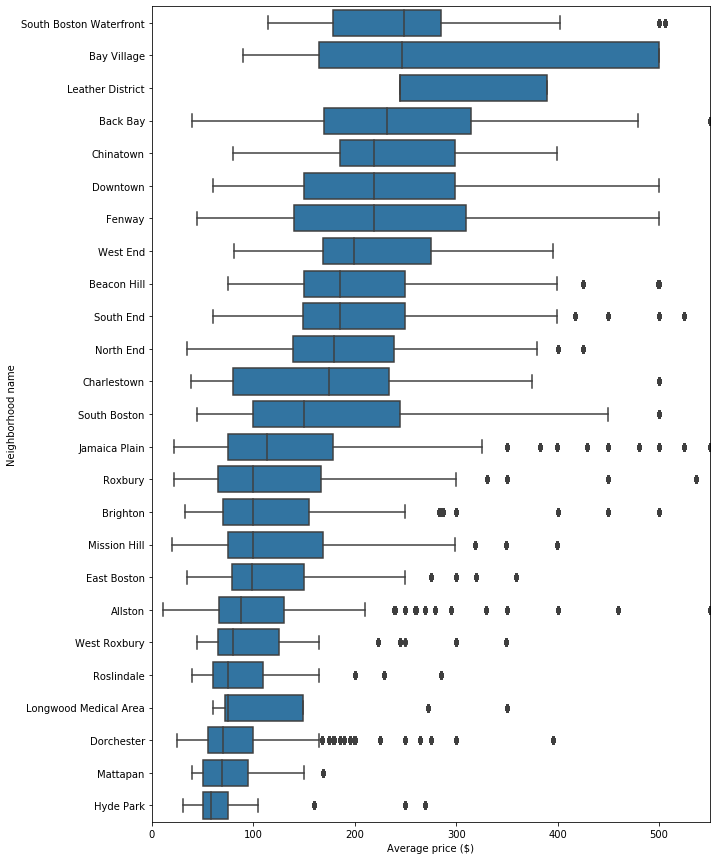

In [45]:
base_color = sb.color_palette()[0]
# Increase plot size
plt.figure(figsize = [10,15])
# order results descendingly by median of original_price
order = df.groupby(['neighbourhood_cleansed']).median().sort_values(['original_price'],ascending=False)['original_price'].index
# plot
sb.boxplot(data = df, y = 'neighbourhood_cleansed',x='original_price', color = base_color,order=order)
plt.xlabel('Average price ($)');
plt.ylabel('Neighborhood name');
# limit the x axis to remove ouliers for better visualization
plt.xlim([0,550]);

We can observe from the above plot how the price varies accross different neighborhood. This answers the first half of the question. In order to answer the other part of the question, we need to see the change in average price, and plot it againest the dates available. We can use a line plot to visualize this.

In [46]:
# We check the range of the dates available in our dataframe
df['date'].max() - df['date'].min()

Timedelta('364 days 00:00:00')

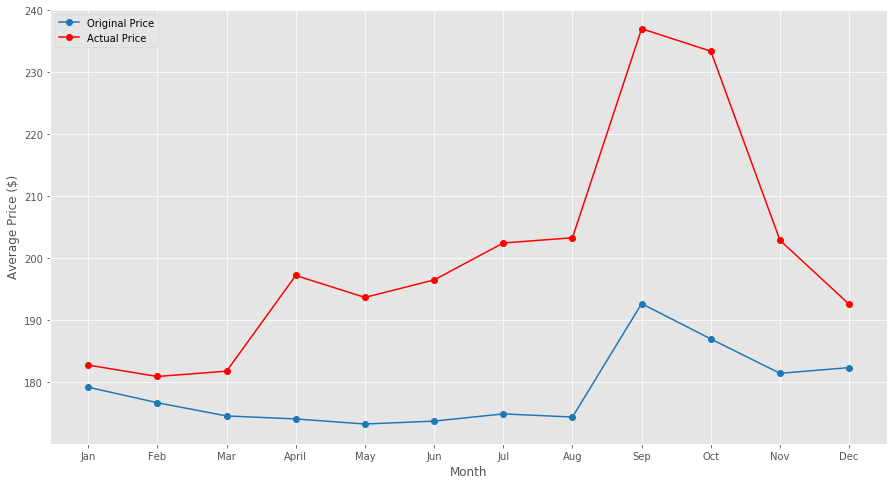

In [47]:
# We create a new column holding the month value of each row
df['month'] = df['date'].dt.month
plt.figure(figsize = [15,8])
plt.style.use('ggplot')

# Plotting
y_org_values = df.groupby(['month'])['original_price'].mean()
y_act_values = df.groupby(['month'])['price'].mean()
x_values = ['Jan', 'Feb', 'Mar', 'April','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(x_values,y_org_values, '-o',color=base_color,label = 'Original Price')
plt.plot(x_values,y_act_values, 'r-o',label = 'Actual Price')

plt.legend(loc="upper left")
plt.xlabel('Month')
plt.ylabel('Average Price ($)');


We can see from the above plot that the change in prices in September and October are highest, and in January is lowest.

For the next question we need to have compare the final review score that we computed earlier, with the time of year.

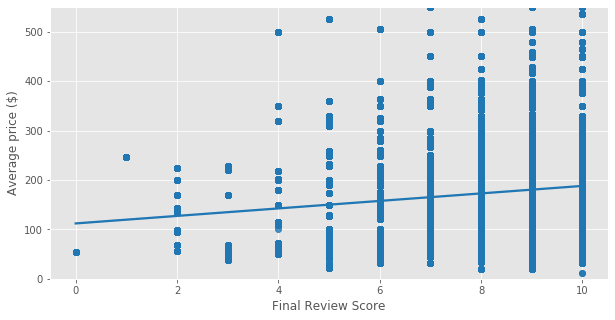

In [48]:
plt.figure(figsize = [10,5])

sb.regplot(data = df, x= 'final_review_score',y='original_price',color=base_color)
plt.ylim(0, 550);
plt.ylabel('Average price ($)');
plt.xlabel('Final Review Score');


As expected, the price shows a linear relationship with the reviws, so a AirBNB houses with higher rating, tend to have higher prices.
Now for the third question, we need to find the relation between in internet availability and the number of listings of an AirBNB home.

Text(0, 0.5, 'Listings')

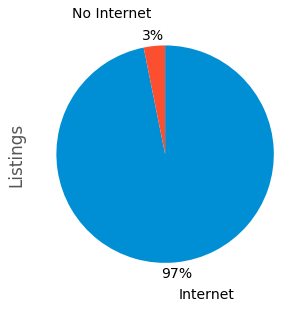

In [49]:
plt.figure(figsize = [5,5])
sorted_counts = df['Internet'].value_counts()
plt.style.use('fivethirtyeight')
plt.pie(sorted_counts,startangle = 90, counterclock = False, labels = ['Internet','No Internet'], autopct='%1.0f%%',\
       pctdistance=1.1,labeldistance=1.3);
plt.ylabel('Listings')

We can see that AirBNB homes with internet availability take up to 97% of the total listings of AirBNB homes! This shows that almost all people are looking for a home with internet service availability. Now, let's see how much this service affect the average price of a home.

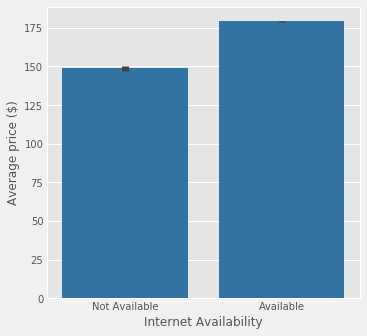

In [50]:
plt.figure(figsize = [5,5])
plt.style.use('ggplot')

sb.barplot(data = df, y = 'original_price',x='Internet', color = base_color)
plt.ylabel('Average price ($)');
plt.xlabel('Internet Availability');

plt.xticks(ticks = [0,1], labels = ['Not Available','Available']);

We can see that internet availability raises the average price of an AirBNB home by almost 30.00$. So to answer the question, a host should definitely invest in making this service available, not only does it raises the price value of the propery, but also draws attention of most people, as this is what they're looking for.

To answer our *4th* question, we can do the same for the Washer/Dryer column.

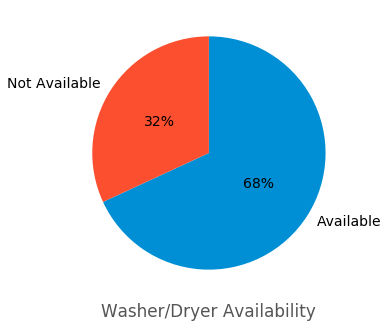

In [51]:
plt.figure(figsize = [5,5])
sorted_counts = df['Washer / Dryer'].value_counts()
plt.style.use('fivethirtyeight')
plt.pie(sorted_counts,startangle = 90, counterclock = False, labels = ['Available','Not Available'], autopct='%1.0f%%',\
       pctdistance=.5,labeldistance=1.1);
plt.xlabel('Washer/Dryer Availability');

68% of listings that occurred throughout the year offered a washer/dryer. This shows that 68% of people prefer a property with a washer/dryer. But how much are they willing to pay to get it?

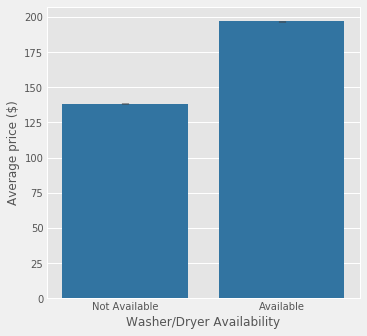

In [52]:
plt.figure(figsize = [5,5])
plt.style.use('ggplot')

sb.barplot(data = df, y = 'original_price',x='Washer / Dryer', color = base_color)
plt.ylabel('Average price ($)');
plt.xlabel('Washer/Dryer Availability');

plt.xticks(ticks = [0,1], labels = ['Not Available','Available']);

We can see that they are willing to pay around 60.00$ for this service which is a big difference compared to the internet service.

Finally, to answer our last question, we can extract our features by first checking the correlation between the **original_price** column and other numeric columns, and select those with high correlation. Instead of using heatmaps,the below code does this in a single line.

In [53]:
df.corr()['original_price'].sort_values(ascending=False)

original_price          1.000000
price                   0.879527
room_Entire home/apt    0.474350
accommodates            0.460641
bedrooms                0.416205
                          ...   
prop_House             -0.141130
reviews_per_month      -0.174394
in_Dorchester          -0.200597
room_Private room      -0.451096
host_is_superhost            NaN
Name: original_price, Length: 128, dtype: float64

We can see from the above plot that useful columns in our case are:
* price
* accommodates
* bedrooms
* beds
* cleaning_fee
* guests_included
* review_scores_location
* latitude
* bathrooms
* host_listing_count

And we can add a couple of columns which we think might have an effect on the price prediction:

* longitude
* final_review_score
* minimum_nights
* Extra People
* availability_30
* month

We should check for missing values in these columns and impute them if any.

In [54]:
df[['price',
'accommodates',
'bedrooms',
'beds',
'cleaning_fee',
'guests_included',
'review_scores_location',
'latitude',
'bathrooms',
'host_listings_count',
'longitude',
'final_review_score',
'minimum_nights',
'extra_people',
'availability_30',
'month']].isnull().sum()

price                     0
accommodates              0
bedrooms                  0
beds                      0
cleaning_fee              0
guests_included           0
review_scores_location    0
latitude                  0
bathrooms                 0
host_listings_count       0
longitude                 0
final_review_score        0
minimum_nights            0
extra_people              0
availability_30           0
month                     0
dtype: int64

Great!, now its time for modeling

### Price prediction

We create the **X** matrix which holds the features of the model, and the **y** matrix which holds the variable that we're trying to predict, in our case the **original_price** variable.

In [55]:
# instead of selecting column by column we get all the numeric columns and drop those we don't need
X = df.select_dtypes(np.number).drop(['listing_id','scrape_id','host_id','reviews_per_month',\
                                      'review_scores_rating','review_scores_communication','review_scores_checkin',\
                                     'review_scores_cleanliness','review_scores_value','review_scores_accuracy',
                                     'host_is_superhost','host_identity_verified','original_price','maximum_nights',\
                                     'availability_60','availability_90','availability_365','number_of_reviews',\
                                     'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',\
                                     'calculated_host_listings_count'],axis = 1)
y = df['original_price']

### Price Prediction Results

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 50)
# instantiate
lm_model = LinearRegression(normalize = True)
# fit
lm_model.fit(X_train, y_train) #training the algorithm
# predict
y_test_pred = lm_model.predict(X_test)
# score
"The r-squared error for the model was {}".format(r2_score(y_test,y_test_pred))

'The r-squared error for the model was 0.8233998285491164'

The r-squared error we got using a linear regression model was 0.8234 which is pretty good.

# Summary

We found from the data how areas and time frames influence the price of an AirBNB home, neighborhoods with highest prices were found to be South Boston Waterfront, Bay Village, and Leather District, while those with low prices are Hyde Park and Mattapan.

We saw how prices change along the year and that it increases in September and October, and decreases in January.

We also saw the relation between review scores and home prices, stating that homes with better review tend to have higher prices, which is expected.

Furthermore, we showed that 97% of people are looking for AirBNB homes with internet availability, and are willing to pay extra 30.00$ for it. So it sounds like a good investment for hosts that don't provide this service yet.

And last but not least, we showed that 68% of people are looking for AirBNB homes that offer washer/dryer. And they can pay up to 60.00$ for it.

Finally we used a linear regression model to predict the price of an AirBnB home, and that gave us an r-squared error of 0.8234